No se encontró una tabla Q guardada, se inicializa una nueva.
Tabla Q guardada exitosamente.


Recompensa promedio: -131.01074070165765


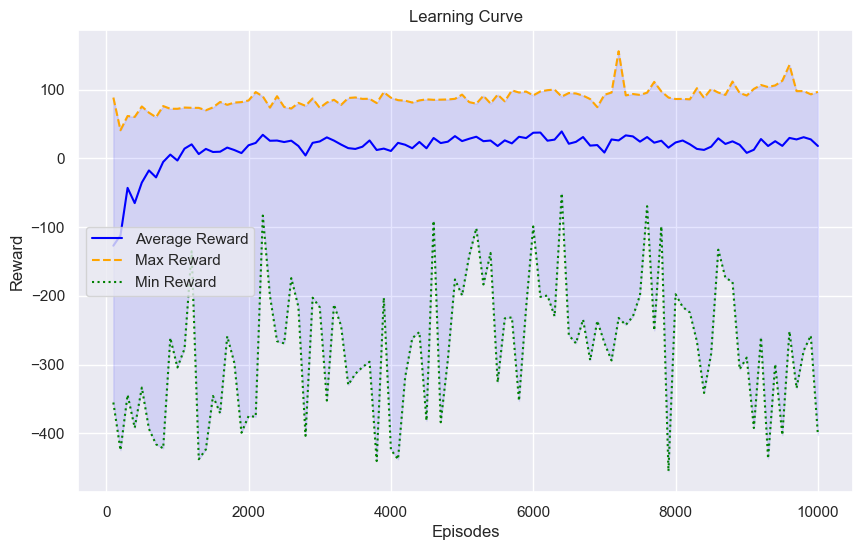

In [17]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

# Definir el entorno
env = gym.make("LunarLander-v2")

# Definir función para serializar estados
def serialize_state(state):
    x, y, vx, vy, theta, vtheta, left_contact, right_contact = state
    x_discrete = np.clip(int(np.digitize(x, np.linspace(-1, 1, 10))), 0, 9)
    y_discrete = np.clip(int(np.digitize(y, np.linspace(-1, 1, 10))), 0, 9)
    vx_discrete = np.clip(int(np.digitize(vx, np.linspace(-1, 1, 10))), 0, 9)
    vy_discrete = np.clip(int(np.digitize(vy, np.linspace(-1, 1, 10))), 0, 9)
    theta_discrete = np.clip(int(np.digitize(theta, np.linspace(-1, 1, 10))), 0, 9)
    vtheta_discrete = np.clip(int(np.digitize(vtheta, np.linspace(-1, 1, 10))), 0, 9)
    left_contact_discrete = int(left_contact)
    right_contact_discrete = int(right_contact)
    
    state_discrete = (x_discrete, y_discrete, vx_discrete, vy_discrete, 
                      theta_discrete, vtheta_discrete, left_contact_discrete, 
                      right_contact_discrete)

    return state_discrete

def plot_rewards(rewards):
    sns.set_theme(style="darkgrid")
    rewards = np.array(rewards)
    block_size = 100  # Aumentar el tamaño del bloque para suavizar más la curva
    num_blocks = len(rewards) // block_size
    avg_rewards = np.mean(
        rewards[: num_blocks * block_size].reshape(-1, block_size), axis=1
    )
    max_rewards = np.max(
        rewards[: num_blocks * block_size].reshape(-1, block_size), axis=1
    )
    min_rewards = np.min(
        rewards[: num_blocks * block_size].reshape(-1, block_size), axis=1
    )
    x = np.arange(1, len(avg_rewards) + 1) * block_size

    plt.figure(figsize=(10, 6))
    plt.plot(x, avg_rewards, label="Average Reward", color="blue")
    plt.plot(x, max_rewards, label="Max Reward", color="orange", linestyle="--")
    plt.plot(x, min_rewards, label="Min Reward", color="green", linestyle=":")
    plt.fill_between(x, min_rewards, max_rewards, color="blue", alpha=0.1)
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()

# Inicializar la tabla Q con valores aleatorios o cargar una tabla existente
state_bins = [10] * 8  # Número de bins por dimensión del estado
num_actions = env.action_space.n  # Número de acciones
Q = np.zeros(state_bins + [num_actions])

try:
    with open("Qlunar.pkl", "rb") as f:
        Q_loaded = pickle.load(f)
    print("Tabla Q cargada exitosamente.")
    Q = Q_loaded
except FileNotFoundError:
    print("No se encontró una tabla Q guardada, se inicializa una nueva.")

# Parámetros de aprendizaje
alpha = 0.3  # Tasa de aprendizaje
gamma = 0.99  # Factor de descuento
epsilon = 0.01  # Probabilidad de exploración

# Almacenar las recompensas por episodio
rewards = []

# Entrenamiento del agente
num_episodios = 10000  # Número de episodios de entrenamiento
max_steps_per_episode = 200  # Número máximo de pasos por episodio

for episode in range(num_episodios):
    state = serialize_state(env.reset()[0])
    done = False
    steps = 0
    total_reward = 0

    while not done and steps < max_steps_per_episode:
        # Seleccionar la acción usando la estrategia Epsilon Greedy
        if random.random() > epsilon:
            # Explotación: seleccionar la acción con mayor valor Q
            action = np.argmax(Q[state])
        else:
            # Exploración: seleccionar una acción aleatoria
            action = random.randrange(env.action_space.n)

        # Ejecutar la acción y obtener la siguiente observación, recompensa y estado final
        new_state, reward, done, _, _ = env.step(action)
        new_state_discrete = serialize_state(new_state)

        # Actualizar la tabla Q utilizando la ecuación de Bellman
        Q[state][action] = Q[state][action] + alpha * (
            reward + gamma * np.max(Q[new_state_discrete]) - Q[state][action]
        )

        # Actualizar el estado actual
        state = new_state_discrete
        steps += 1
        total_reward += reward

    # Almacenar la recompensa del episodio actual
    rewards.append(total_reward)

# Guardar la tabla Q actualizada
with open("Qlunar.pkl", "wb") as f:
    pickle.dump(Q, f)
    print("Tabla Q guardada exitosamente.")

# Evaluación del agente
num_eval_episodes = 10  # Número de episodios de evaluación
total_reward = 0

for episode in tqdm(range(num_eval_episodes), desc="Training Episodes", leave=False):
    state = serialize_state(env.reset()[0])
    done = False

    while not done:
        # Seleccionar la acción con mayor valor Q
        action = np.argmax(Q[state])

        # Ejecutar la acción y obtener la siguiente observación, recompensa y estado final
        new_state, reward, done, _, _ = env.step(action)
        new_state_discrete = serialize_state(new_state)

        # Actualizar la recompensa total
        total_reward += reward

        # Actualizar el estado actual
        state = new_state_discrete

# Imprimir la recompensa promedio
average_reward = total_reward / num_eval_episodes
print("Recompensa promedio:", average_reward)

# Visualizar la curva de aprendizaje
plot_rewards(rewards)
